In [1]:
%pylab
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from collections import namedtuple
from scipy.spatial.distance import pdist, squareform, cdist

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import wfg

In [3]:
figsize(8,8)

Text(0.5, 0.98, 'WFG2')

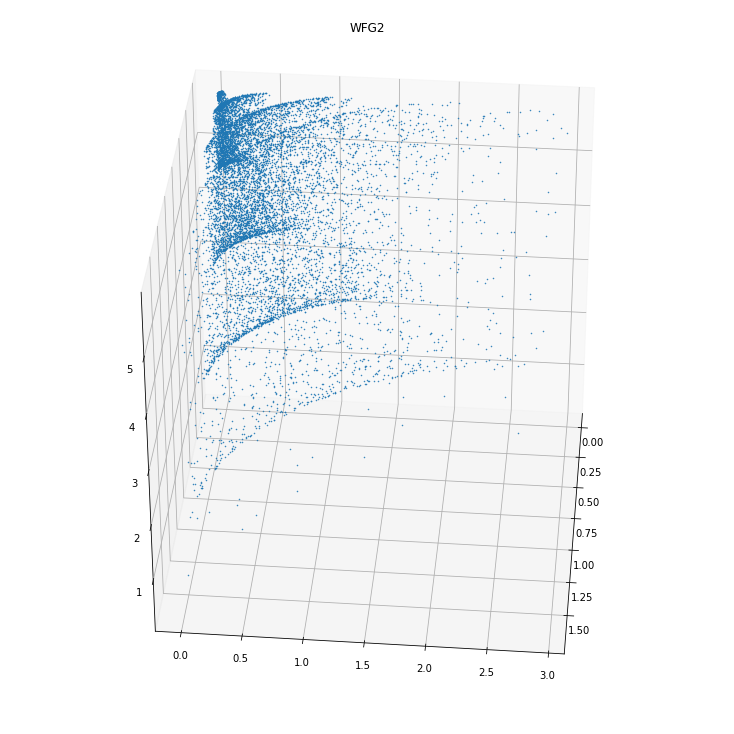

In [5]:
N = 10000
M = 3                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2


wfgparams = namedtuple('WFGparams', ['M', 'k', 'l'])
wfg3obj = wfgparams(M=3, k=k, l=l)

func = wfg.WFG2

f = np.zeros((N, M))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    f[n,:] = func(z, k, M)


fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot(*f.T, '.', ms=1)
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)

In [6]:
wfgparams = namedtuple('WFGparams', ['M', 'k', 'l'])
wfg2obj = wfgparams(M=3, k=k, l=l)
wfg2obj

WFGparams(M=3, k=4, l=4)

In [7]:
def notDominated(X):
    """
    Return a Boolean vector with as many rows as X indicating whether each
    row of X is not dominated by the other elements of X; ie, whether each
    row is Pareto optimal for X.
    """
    y = zeros(X.shape[0], dtype='bool')
    for n in range(X.shape[0]):
        # Find the number of times on each row where X[i,j] >= X[n,j];
        # y[n] is not dominated if this is bigger than for every row
        y[n] = min(sum(X >= X[n,:], 1)) > 0
    return y

In [8]:
I = notDominated(f)
F = f[I,:]
F.shape

(2452, 3)

Text(0.5, 0.98, 'WFG2')

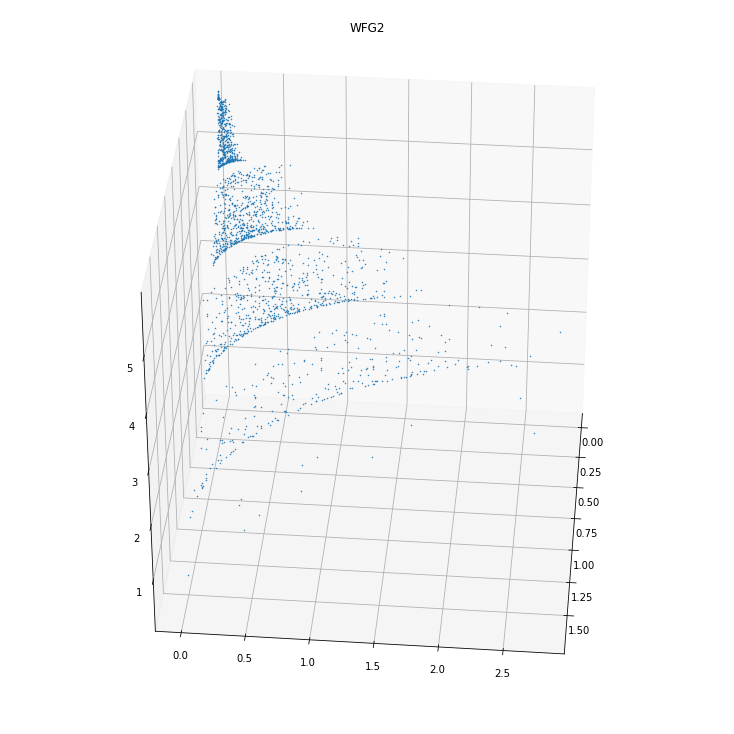

In [9]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot(*F[:2000,:].T, '.', ms=1)
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)

### Maximise the minimum nearest neighbour distance

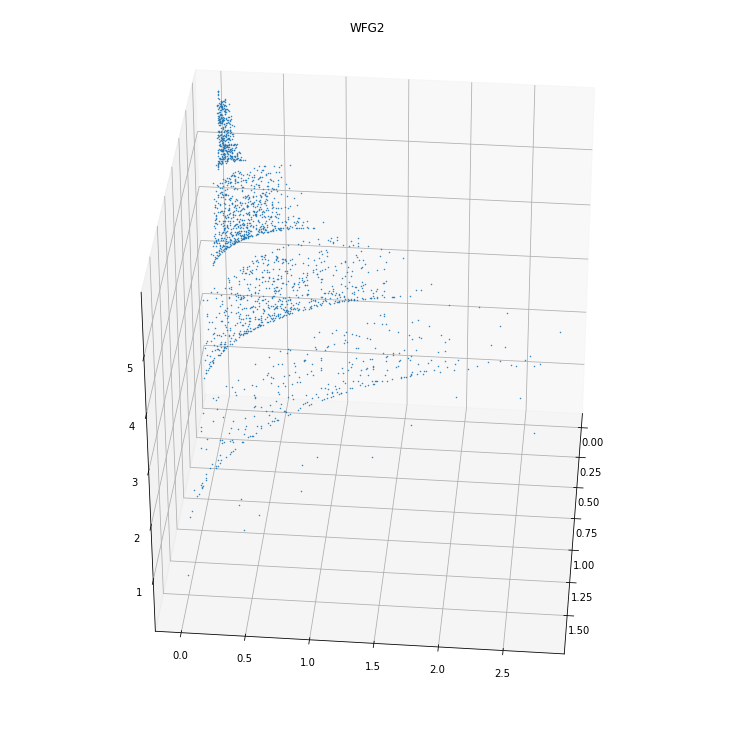

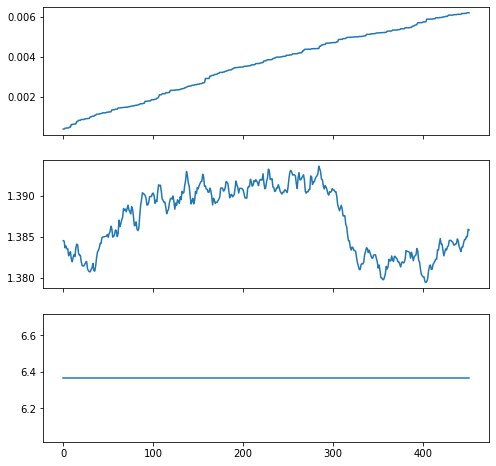

In [10]:
M = 2000  # Number of points required

X = F[:M,:]
Y = F[M:,:]

D = squareform(pdist(X))
np.fill_diagonal(D, np.nan)
d = np.nanmin(D, axis=0)    # Nearest neighbour distances

mind, medd, maxd = [], [], []
for y in Y:
    dp = cdist(y[np.newaxis,:], X)[0]  # Distance of y to each element of X
    
    if np.nanmin(dp) > np.nanmin(d):
        # Insert y instead of one of the points that has the min nn distance in X
        # thus increasing the min nn distance
        i = np.nanargmin(d)

        X[i,:] = y[:]
        D[i,:] = dp
        D[:,i] = dp
        D[i,i] = np.nan
        d[i] = np.nanmin(dp)

    
    mind.append(np.nanmin(D))
    maxd.append(np.nanmax(D))
    medd.append(np.nanmedian(D))

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot(*X.T, '.', ms=1)
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)

fig, ax = plt.subplots(3, 1, sharex=True)
for a, z in zip(ax, (mind, medd, maxd)):
    a.plot(z)


### Sample from the attainment surface 

In [9]:
def weak_dominates(Y, x):
    """
    Test whether rows of Y weakly dominate x
    
    Parameters
    ----------
    Y : array_like
        Array of points to be tested. 
        
    x : array_like
        Vector to be tested
        
    Returns
    -------
    c : ndarray (Bool)
        1d-array.  The ith element is True if Y[i] weakly dominates x
    """
    return (Y <= x ).sum(axis=1) == Y.shape[1]


def attainment_sample(Y, Nsamples=1000):
    """
    Return samples from the attainment surface defined by the mutually non-dominating set Y

    Parameters
    ---------
    Y : array_like
        The surface to be sampled. Each row of Y is vector, that is mutually
        with all the other rows of Y
    Nsamples : int
        Number of samples

    Returns
    -------
    S : ndarray
        Array of samples from the attainment surface.
        Shape; Nsamples by Y.shape[1] 
    
    Notes
    -----
    See "Dominance-based multi-objective simulated annealing"
    Kevin Smith, Richard Everson, Jonathan Fieldsend, 
    Chris Murphy, Rashmi Misra.
    IEEE Transactions on Evolutionary Computing. 
    Volume: 12, Issue: 3, June 2008.
    https://ieeexplore.ieee.org/abstract/document/4358782
    """
    N, D = Y.shape
    Ymin = Y.min(axis=0)
    r = Y.max(axis=0) - Ymin
    S = np.zeros((Nsamples, D))
    
    # Set up arrays of the points sorted according to each coordinate.
    Ys = np.zeros((N, D))
    for d in range(D):
        Ys[:,d] = np.sort(Y[:,d])

    for n in range(Nsamples):
        v = np.random.rand(D)*r + Ymin
        m = np.random.randint(D)

        # Bisection search to find the smallest v[m] 
        # so that v is weakly dominated by an element of Y
        lo, hi = 0, N
        while lo < hi:
            mid = (lo+hi)//2
            v[m] = Ys[mid,m]
            if not any(weak_dominates(Y, v)):
                lo = mid+1
            else:
                hi = mid
        if lo == N: lo -= 1
        v[m] = Ys[lo, m]      
        assert lo == N-1 or any(weak_dominates(Y, v))
        S[n,:] = v[:]
    return S


#### Example in 2D

In [32]:
N = 10000
M = 2                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

wfg2obj = wfgparams(M=M, k=k, l=l)
func = wfg.WFG2

f = np.zeros((N, M))
z = np.zeros((N, k+l))
for n in range(N):
    z[n,:] = wfg.random_soln(k, l, func.__name__)
    f[n,:] = func(z[n,:], k, M)




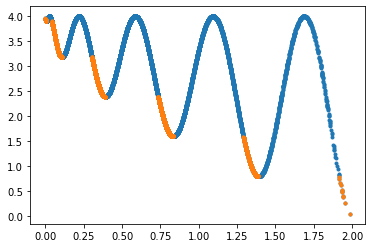

In [33]:
I = notDominated(f)
F = f[I,:]
Z = z[I,:]
plt.plot(*f.T, '.')
plt.plot(*F.T, '.')

### Interpolate between two solutions on the front

[1.93438324 0.49035305]
[1.94112704 0.40545851]
[1.94248885 0.38916631]
0.8389443369442643
[1.94585414 3.94117001 2.1        2.8        3.5        4.2       ]
[1.94046401 3.96927495 2.1        2.8        3.5        4.2       ]
[1.97738726 3.89528507 2.1        2.8        3.5        4.2       ]
[1.93942925 3.97467037 2.1        2.8        3.5        4.2       ]

Function value for interpolated point should be close to bf
[1.94118333 0.4047794 ]
[1.94112704 0.40545851]


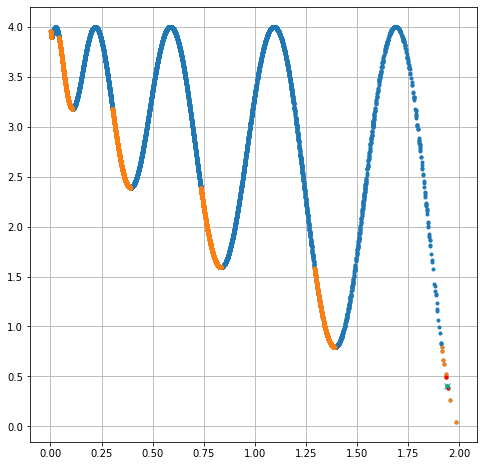

In [37]:
# Get the three solutions with the largest f[1] < 0.5 
J = f[:,1] < 0.5

ff = f[J,:]
zz = z[J,:]
J = argsort(ff[:,1])
ff = ff[J,:]
zz = zz[J,:]

af = ff[-1,:]
az = zz[-1,:]
bf = ff[-2,:]
bz = zz[-2,:]
cf = ff[-3,:]
cz = zz[-3,:]

plt.plot(*f.T, '.')
plt.plot(*F.T, '.')
for q in (af, cf):
    plt.plot(*q, 'r.')
plt.plot(*bf, 'g.')
grid()

print(af)
print(bf)
print(cf)

alpha = norm(bf-af)/norm(cf-af)
print(alpha)

# Interpolate the decision space point
iz = az + alpha*(cz-az)
print(az)
print(iz)
print(bz)
print(cz)

print('\nFunction value for interpolated point should be close to bf')
bfi = func(iz, wfg2obj.k, wfg2obj.M)
print(bfi)
print(bf)

plt.plot(*bfi, 'cx')

### Interpolate across a gap

0.5000000000000001
[1.23883946 2.34964588 2.1        2.8        3.5        4.2       ]
[1.60826662 2.27415739 2.1        2.8        3.5        4.2       ]
[1.97769378 2.1986689  2.1        2.8        3.5        4.2       ]

Function value for interpolated point will be far from bf
[1.05398399 3.87546465]
[1.06199746 1.58987184]


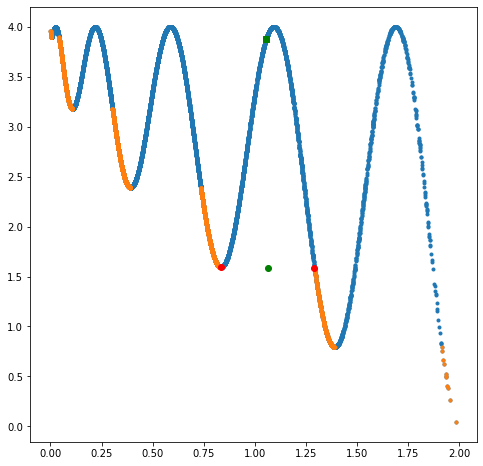

In [38]:
# Find the samples at either end of a gap
J = F[:,0] < 1
ff = F[J,:]
zz = Z[J,:]
i = argmax(ff[:,0])

af = ff[i,:]
az = zz[i,:]

J = F[:,0] > 1
ff = F[J,:]
zz = Z[J,:]
i = argmin(ff[:,0])

cf = ff[i,:]
cz = zz[i,:]

plt.plot(*f.T, '.')
plt.plot(*F.T, '.')
plt.plot(*af, 'ro')
plt.plot(*cf, 'ro')

# Make a point halfway between in function space
bf = (af + cf)/2
alpha = norm(bf-af)/norm(cf-af)
print(alpha)

# Interpolate the decision space point
iz = az + alpha*(cz-az)
print(az)
print(iz)
print(cz)

print('\nFunction value for interpolated point will be far from bf')
bff = func(iz, wfg2obj.k, wfg2obj.M)
print(bff)
print(bf)
plt.plot(*bf, 'go')
plt.plot(*bff, 'gs')

### Densification of samples on the front and identification of holes

(267, 3)


Text(0.5, 0.98, 'WFG2')

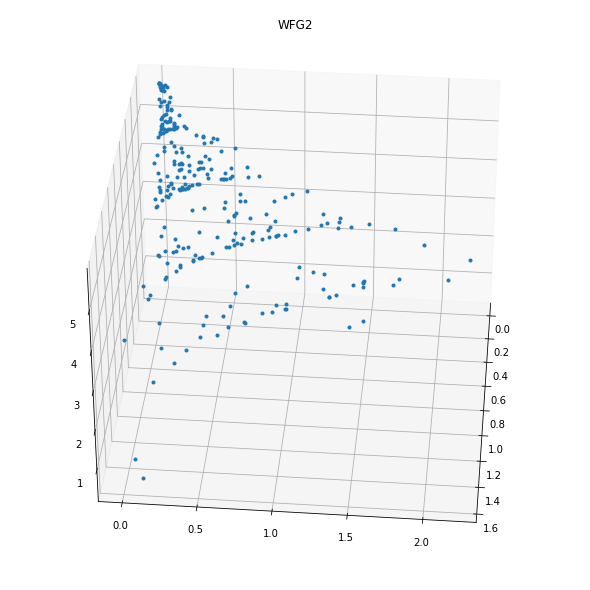

In [134]:
N = 1000
M = 3                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2
wfg3obj = wfgparams(M=M, k=k, l=l)


f3 = np.zeros((N, M))
z3 = np.zeros((N, k+l))
for n in range(N):
    z3[n,:] = wfg.random_soln(wfg3obj.k, wfg3obj.l, func.__name__)
    f3[n,:] = func(z3[n,:], wfg3obj.k, wfg3obj.M)
    

I = notDominated(f3)
f3 = f3[I,:]
z3 = z3[I,:]
print(f3.shape)

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
plt.plot(*f3.T, '.')
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)



```
Generate samples, (z,f), on the manifold 
F = nondom(f)
A = attainment_sample(F)   # A denser sampling including gaps

while largest nn distance > delta:
    f = point in A with largest distance to a point in F
    g = construct an interpolant from the nearest neighbours
    if g is far from f then f is in a hole
```

In [85]:
from sklearn.neighbors import NearestNeighbors
import os 
sys.path.append(os.path.expanduser("~/projects/ndvis/ndvis/"))
import Simplex

from scipy.spatial import Delaunay, delaunay_plot_2d

(400, 5)
[4.89331696e+01 1.10323458e+01 6.55260149e-15]


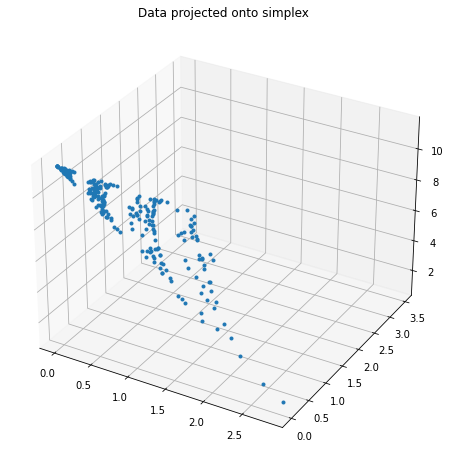

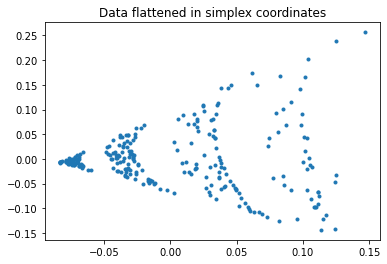

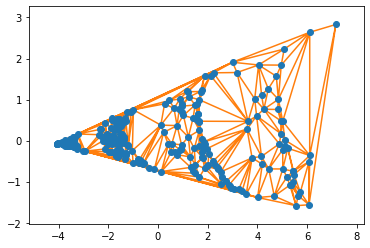

In [140]:

F = f3
Z = z3
M = 3

A = attainment_sample(F, 400)


NN = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(F)

distance, ind = NN.kneighbors(A)

print(distance.shape)

# Project the data onto a simplex and find the Delaunay triangulation 
# of the points on the simplex so that we can find points that 'surround' 
# a query point. 
sim = Simplex.Simplex(2*F.max(axis=0))
Fsim = sim.inSimplexCoords(F)
Fsimbar = Fsim.mean(axis=0)
U, s, V = np.linalg.svd(Fsim-Fsimbar, full_matrices=False)
print(s)
Fsimp = (Fsim - Fsimbar) @ V[:M-1,:].T
tri = Delaunay(Fsimp)


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

plt.plot(*Fsim.T, '.')
plt.title('Data projected onto simplex')

plt.figure()
plt.plot(U[:,0], U[:,1], '.')
plt.title('Data flattened in simplex coordinates')

_ = delaunay_plot_2d(tri)

NameError: name 'A' is not defined

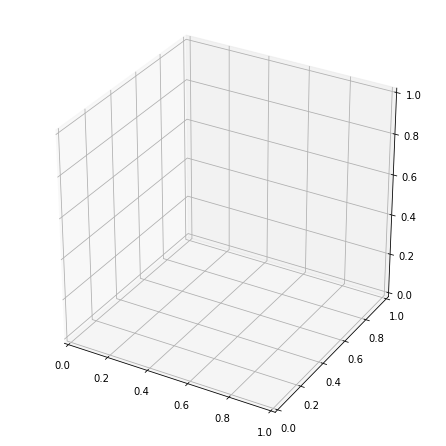

In [11]:
delta = 0.01

%matplotlib inline
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

for n in range(A.shape[0]):
    print('Distance', distance[n,0])
    if distance[n, 0] < delta:
        plt.plot(*A[n], 'r.')
        # continue                 # Close enough to a point on the front
    
    # Interpolate to A[n] from the vertices that make up
    # the simplex which contains A[n]. Find the vertices by 
    # projecting A[n] onto the simplex and then into the simplex coordinates
    ap = sim.inSimplexCoords(np.atleast_2d(A[n]))
    a = (ap - Fsimbar) @ V[:M-1,:].T
    I = Delaunay.find_simplex(tri, np.atleast_2d(a))
    if I[0] == -1:
        print('Outside convex hull')
        continue

    neighbours = tri.simplices[I[0]]
    Fneighbours = F[neighbours]
    print('neighbours = ', neighbours)
    
    w = np.linalg.pinv(Fneighbours.T) @ np.squeeze(A[n])
    Ap = Fneighbours.T @ w
    print(w)
    print('A[n] =', A[n])
    print('Ap = ', Ap)
    print('Difference in A[n] - Ap', norm(A[n]-Ap))
    
    z = Z[neighbours].T @ w
    finterp = func(z, wfg3obj.k, wfg3obj.M)
    
    print('fint =', finterp, '++' if np.linalg.norm(finterp-A[n]) < 0.1 else '')
    print()
    plt.plot(*finterp, marker='o', ls='-', 
             c = 'tab:green' if np.linalg.norm(finterp-A[n]) < 1. else 'tab:purple')

